# Trabajo Práctico 1

In [1]:
# Para no tener que reiniciar el kernel de jupyter cuando se hacen cambios en el archivo .py
%load_ext autoreload
%autoreload 2

In [2]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from template_funciones import *


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

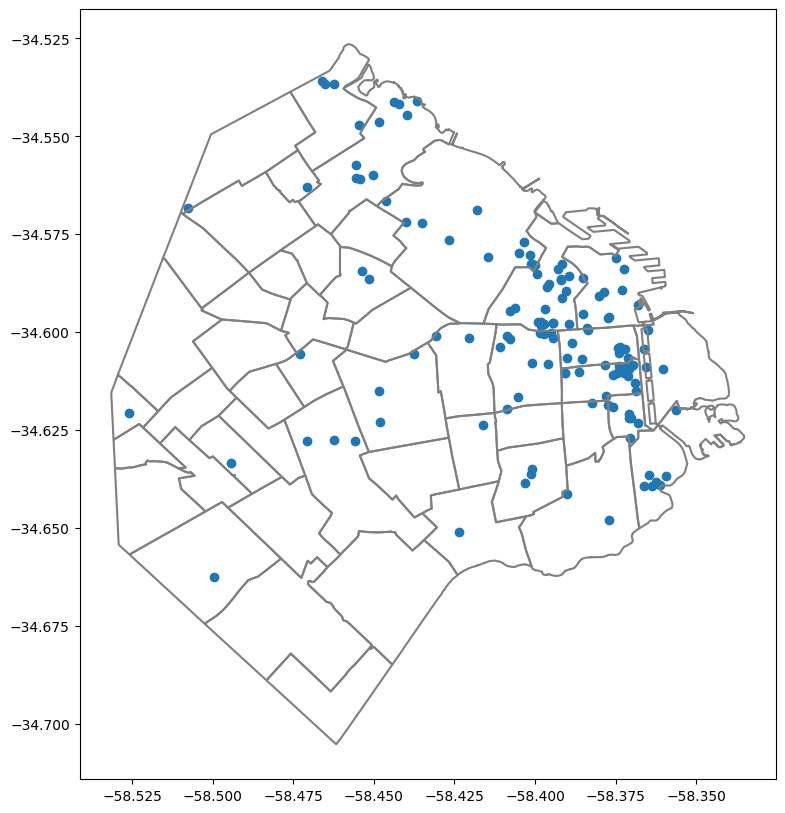

In [4]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [5]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [6]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [7]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

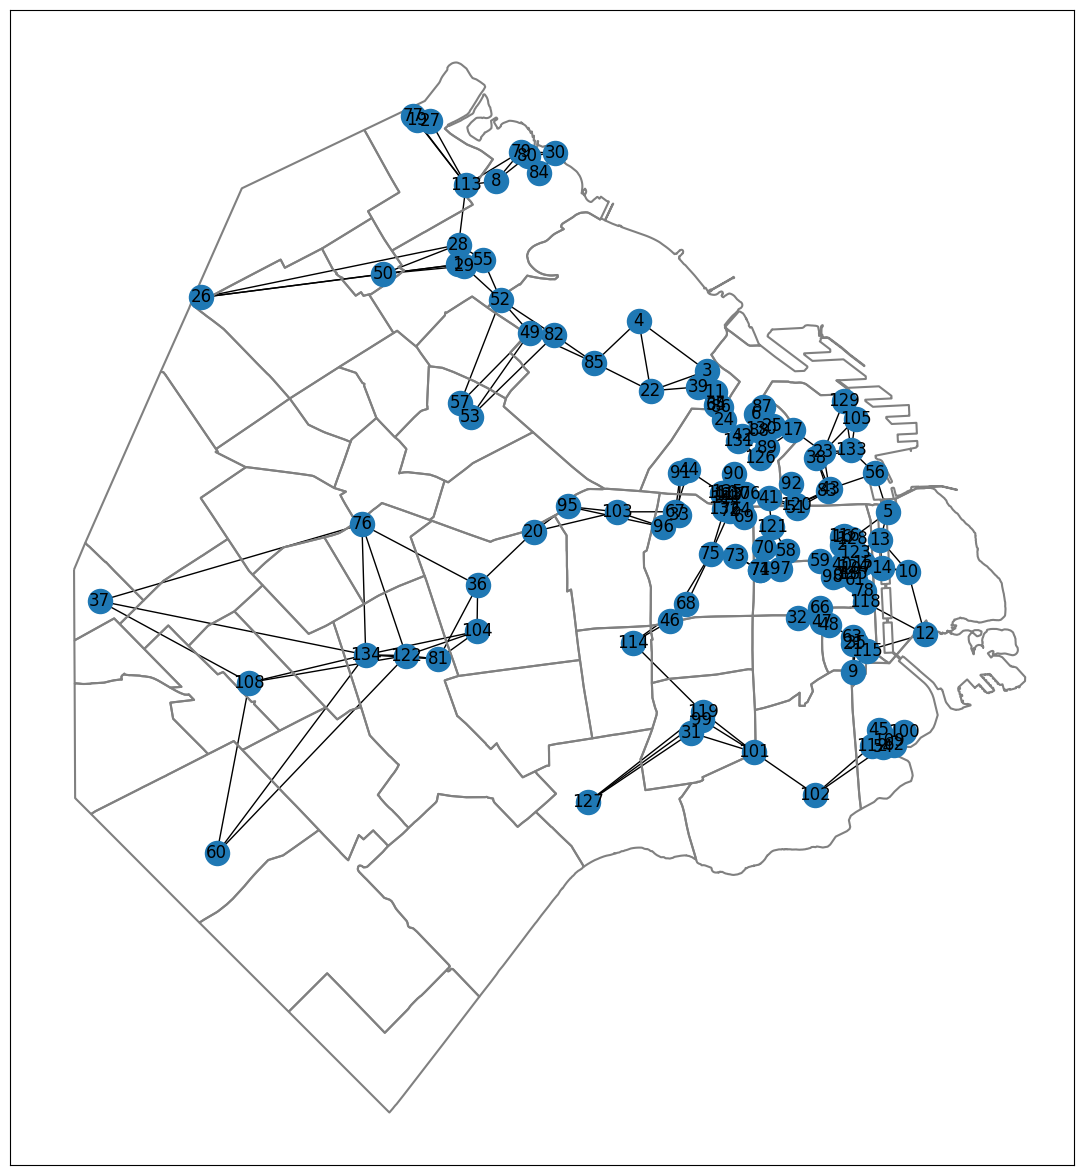

In [8]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución

## Punto 1:

Partiendo de la definicion de $p$
$$ p = (1-\alpha)Cp + \frac{\alpha}{N}\textbf{1} $$
$$ p - (1-\alpha)Cp = \frac{\alpha}{N}\textbf{1} $$
$$ (I - (1-\alpha)C)p = \frac{\alpha}{N}\textbf{1} $$
$$ \frac{N}{\alpha}(I - (1-\alpha)C)p = \textbf{1} $$
$$Mp = \textbf{1} = b \tag{1}$$
Se llega al sistema. Por lo tanto $p$ es solucion del sistema por su definicion.

$\square$

## Punto 2:



Primero que nada, vamos a demostrar que dado $A \in \mathbb{K}^{n \times n}$ y $k \in \mathbb{K}$, entonces
$$ \det(kA)=k^n \cdot \text{det}(A) \tag{2}$$

Para eso, utilizaremos que si $B$ es la matriz que resulta de multiplicar la $r$-ésima columna de $A$, entonces 
$$\det (B) = k \cdot \det (A) \tag{3}$$
<u>Demostración de (3):</u>

Consideremos $E_r(k)$ la matriz elemental que es igual a la identidad salvo por el elemento $\bigl[ E_r(k) \bigr]_{rr}$ que es $k$. Es facil ver que $B=A\,E_r(k)$.

Luego, como $E_r(k)$ es diagonal, su determinante es el producto de los elementos de la diagonal principal, es decir 

$$\det\bigl(E_r(k)\bigr)= \prod_{i=1}^{n}\bigl[ E_r(k) \bigr]_{ii} = k.$$

Sabemos que $\det(CD)=\det(C)\det(D)$ para $C,D \in \mathbb{K}^{n \times n}$, por lo tanto:

$$\det(B)=\det\bigl(A\,E_r(k)\bigr)=\det(A)\cdot\det\bigl(E_r(k)\bigr)=\det(A)\cdot k.$$

con lo cual $\det(B)=k\cdot\det(A)$.

$\square$


<u>Demostración de (2):</u>

Sea $A^{(r)}$ la matriz que se obtiene de $A$ al multiplicar por $k$ las primeras $r$ columnas (las $n-r$ columnas restantes quedan igual), notar que $A^{(0)} = A$ y $A^{(n)} = kA$

**Inducción en $r$**

<u>Caso base:</u> $r = 0$

$$\det\bigl(A^{(0)}\bigr) \overset{\text{por }(3)}{=} k^0 \cdot \det(A) = \det(A)$$ 

<u>Paso inductivo:</u>  Supongamos que vale que $\det(A^{(r)})=k^r\det(A)$ para $0 < r < n$. Notar que $A^{(r+1)}$ se obtiene multiplicando $A^{(r)}$ por $k$, entonces:

$$\det\bigl(A^{(r+1)}\bigr) \overset{\text{por }(3)}{=} k * \det\bigl(A^{(r)}\bigr) \overset{\text{por HI}}{=} k(k^r \det(A)) = k^{r+1}\det(A)$$

Por lo tanto, queda probado $(3)$ por inducción

$\square$

Retomando nuestra demostración original.

Para que la ecuación $(1)$ tenga una única solucion, la matriz $M$ debe ser invertible. Para que $M$ sea invertible su determinante debe ser distinto de 0, es decir $ \text{det}(M) \neq 0 $

Usando que $\text{det}(kA)=k^n \cdot \text{det}(A)$, tenemos que

$$ \text{det}(M) = \text{det}(\frac{N}{\alpha}(I-(1-\alpha)C))\overset{(2)}{=}(\frac{N}{\alpha})^N \text{det}(I-(1-\alpha)C) $$

$\frac{N}{\alpha}$ es un escalar positivo, ya que $N > 0$ y $0 < \alpha < 1$, por lo cual $\text{det}(M) \neq 0$ si y sólo si $\text{det}(I - (1-\alpha)C)\neq 0$.

Probar que el determinante no es nulo es equivalente a probar si la matriz es inversible, así que ahora vamos a probar si la matriz $I - (1-\alpha)C$ es inversible. 

Sabemos que $C$ es una matriz estocástica por columnas, por lo que $||C||_1 = 1$ y ya que $0 < \alpha <1$ entonces $0 < (1 - \alpha) < 1$. Llamo $\beta$ a $1-\alpha$.

Con esto podemos decir que $0 < ||\beta C||_1 < 1$ ya que $||\beta C||_1 = |\beta|·||C||_1$ y $|\beta| = \beta$ porque $\beta > 0$.
  
Ahora vamos a probar que la matriz $I - \beta C$ es inversible debido a que $||\beta C||_1 < 1$.

Si no fuera inversible, existiría un vector no nulo $x$ tal que: 

$$ (I - \beta C)x = 0 \implies x - (\beta C)x = 0 \implies x = (\beta C)x \implies ||x||_1 = ||(\beta C)x||_1 $$

Por la propiedad submultiplicativa de las normas matriciales:

$$ ||(\beta C)x||_1 \leq ||x||_1 · ||(\beta C)||_1 $$

y ya que $||x||_1 = ||(\beta C)x||_1$ entonces:

$$ ||x||_1 \leq ||x||_1 · ||(\beta C)||_1 \implies 1 \leq ||(\beta C)||_1 $$

Lo cual es un absurdo ya que partimos de la hipótesis de que $||(\beta C)||_1 < 1$.

Por lo que $(I - \beta C)$ debe ser inversible lo que implica que $\text{det}(I - (1-\alpha)C)\neq 0$.

$\square$

## Punto 3:

#### Funciones auxiliares

Para calcular los ranks, primero queremos hacer una función para calcular la matriz de grados $K$.

La función $\texttt{construir\_matriz\_grado}$ toma como parametro de entrada la matriz de adyacencias $A$ que construimos a partir de leer los datos de los museos y calculando sus distancias y retorna la matriz de grados $K$ donde

$$ K_{ij} = \begin{cases} 
\sum^{N}_{h=1} A_{ih}, \qquad i=j \\
0, \qquad \qquad \quad i\neq j
\end{cases} $$

Luego, necesitamos la inversa $K^{-1}$, esto lo podemos calcular facilmente aprovechando que $K$ es una matriz diagonal. 

Creamos la función $\texttt{inversa\_de\_triangular}$ toma como entrada una matriz triangular $M$ y devuelve la matriz inversa $M^{-1}$ que resulta de reemplazar cada elemento de la diagonal de $M$ por su inverso multiplicativo.

La función $\texttt{calcular\_matriz\_C}$ toma la matriz $A$, calcula $K$ y retorna $C = A^T K^{-1}$.

#### Cálculo de Page Ranks

La solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ será la matriz de puntajes.

Para resolver el sistema creamos la función $\texttt{calcular\_page\_ranks}$ toma una matriz de transiciones $C$, construye la matriz $M=\frac{N}{\alpha}(I-(1-\alpha)C)$ y retorna la solución al sistema $M\textbf{p}=\textbf{b}$ con $\textbf{b} = \textbf{1}$ utilizando descomposición LU.

### 3)1) Prueba con m y α fijos

Construimos la red conectando a cada museo con sus $m = 3$ vecinos más cercanos y procedemos a graficar la red asignando un tamaño proporcional a cada nodo según su Page Rank, para ello utilizamos la función $\texttt{calcular\_p}$ que llama a la función $\texttt{calcular\_page\_ranks}$ anteriormente definida, devolviendo el vector $p$ normalizado.

In [9]:

Nprincipales = 5 # Cantidad de principales
m = 3 # Cantidad de vecinos mas cercanos
alpha = 1/5 # factor de dumping
pr = calcular_p(D, m, alpha)

# identificar museos mas centrales
principales = np.argsort(pr)[-3:] #> Aca iba Nprincipales
print("Museos con mas ranking ordenados de menor a mayor ranking")
print([museos.loc[i, 'name'] for i in principales])

Museos con mas ranking ordenados de menor a mayor ranking
['Museo de la Ciudad', 'Museo de la Facultad de Odontología', 'Museo de Farmacobotánica']


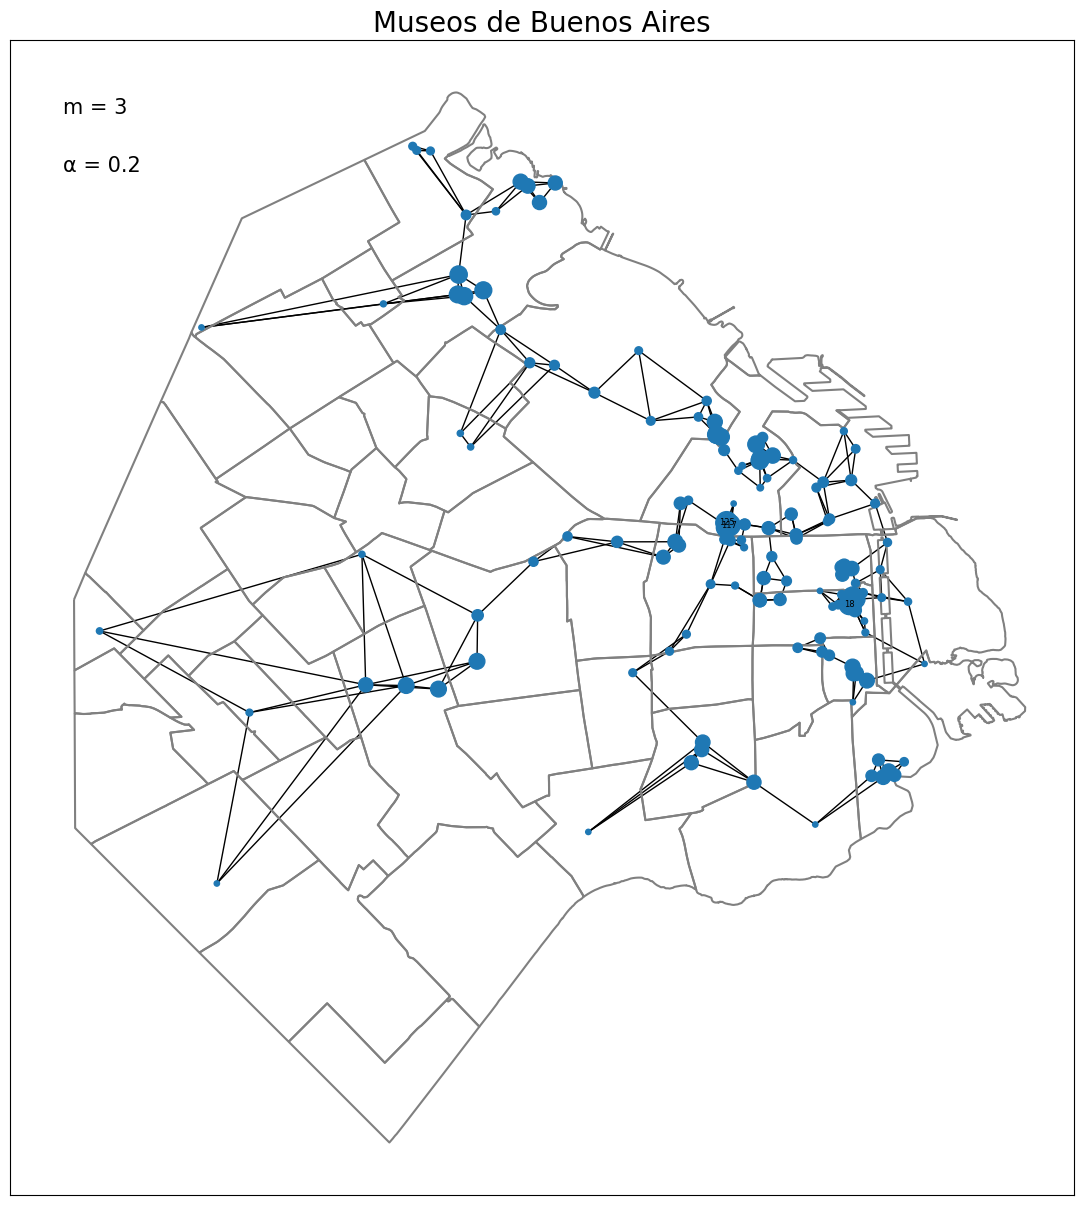

In [10]:
graficar_red_p(pr, A, m, alpha, museos, barrios) #> El Nprincipales de arriba?

Los Museos de la Ciudad, de la Facultad de Odontología y de Farmacobotánica son los mas centrales en estos parametros.

### 3)2) Variando la cantidad de conexiones
m = 1, 3, 5, 10 y usando α = 1/5

In [11]:
ms = [1, 3, 5, 10] 
alpha = 1/5
ps = [] # Lista de scores page rank para cada m y α
for m in ms:
    pr = calcular_p(D, m, alpha)
    ps.append(pr)

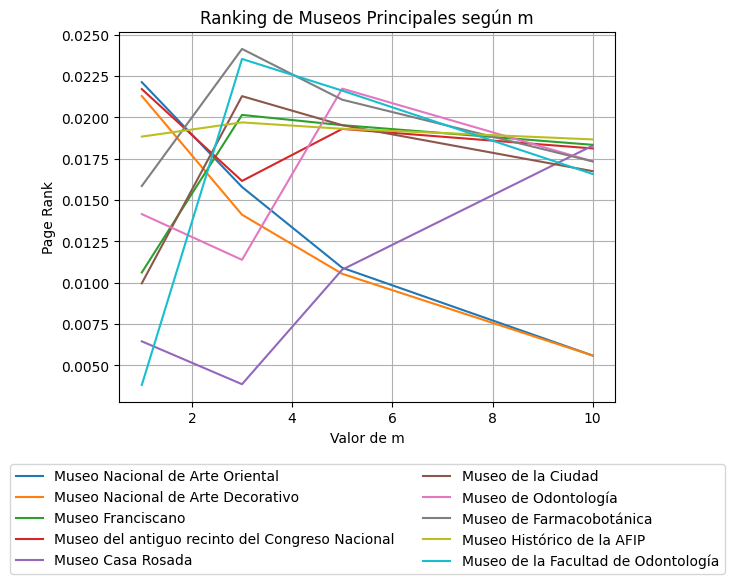

In [12]:
def graficar_museos_principales_por_M(ps, ms):
    # Grafica cómo cambia el ranking de los 3 principales museos para distintos valores de M.
    tres_principales_cada_m = []
    for i, p in enumerate(ps):
        principales = np.argsort(p)[-3:]
        tres_principales_cada_m.append(principales)
    
    tres_principales_cada_m = np.array(list(set(np.hstack(tres_principales_cada_m)))) # Eliminar duplicados con set

    nombres_museos = [museos.loc[i, 'name'] for i in tres_principales_cada_m] # Sacamos los nombres del dataframe

    for i, museo_i in enumerate(tres_principales_cada_m):
        ranking = [p[museo_i] for p in ps]
        plt.plot(ms, ranking, label=nombres_museos[i])

    plt.xlabel('Valor de m')
    plt.ylabel('Page Rank') 
    plt.title('Ranking de Museos Principales según m')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=2) # Para que los labels no tapen el grafico y queden abajo.
    plt.grid(True)
    plt.show()


graficar_museos_principales_por_M(ps, ms)

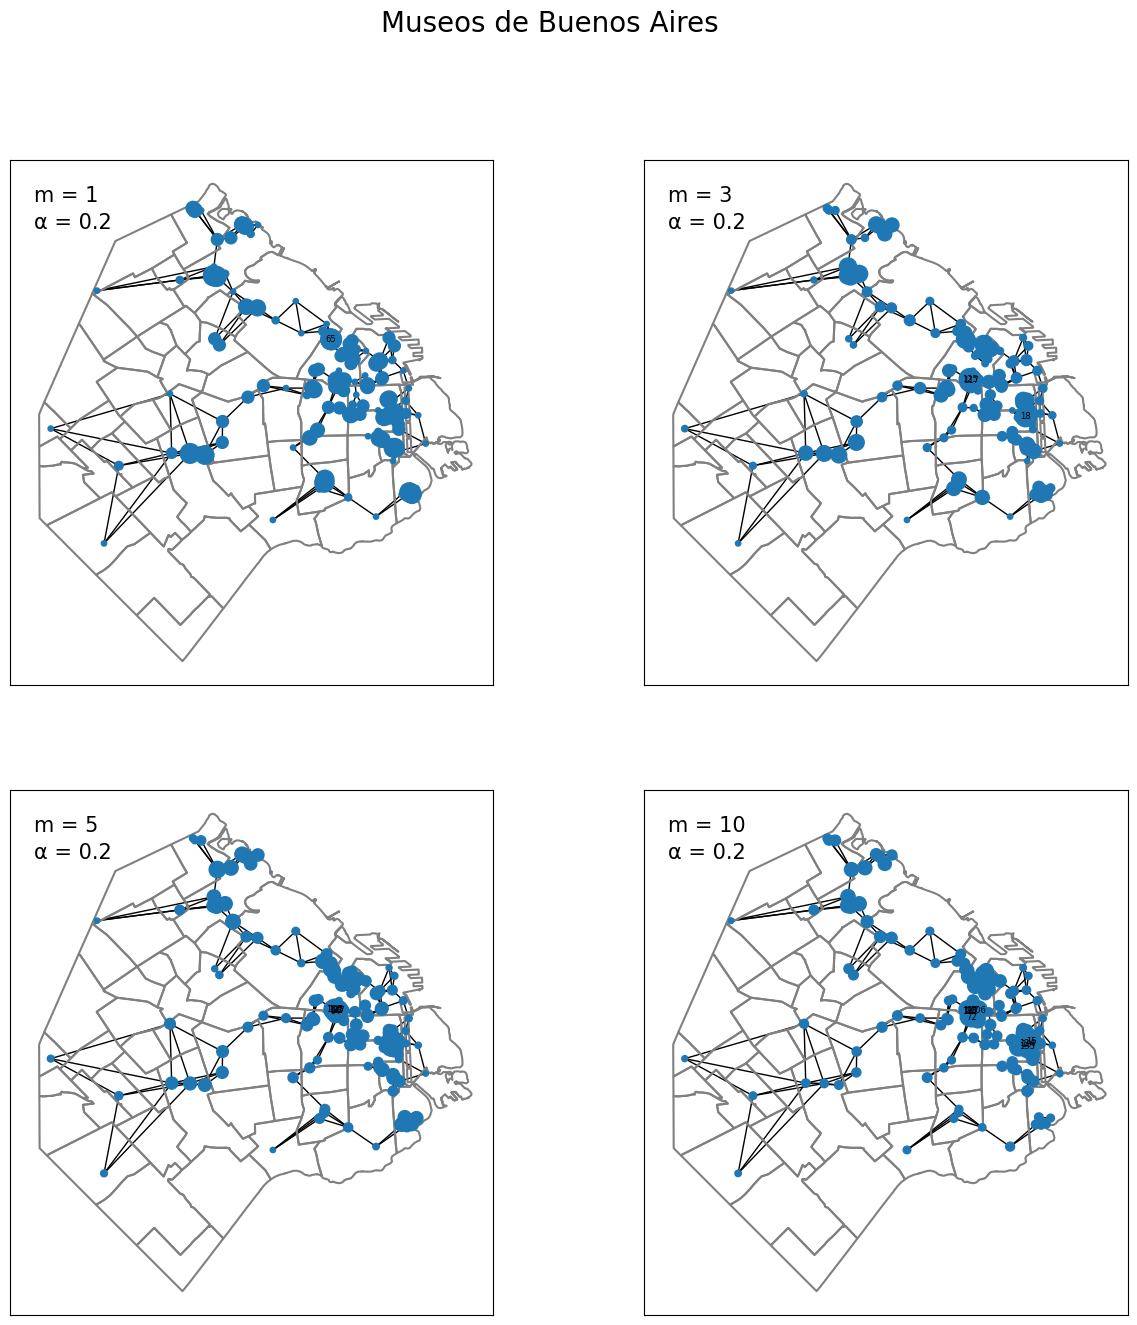

In [13]:
# Mapas para cada par m, α
graficar_red_p_multiple_2x2(ps, A, ms, alpha, museos, barrios)

> VALEN: Junten los gráficos

### 3)3) Variando el parametro α

 m = 5 y α = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7

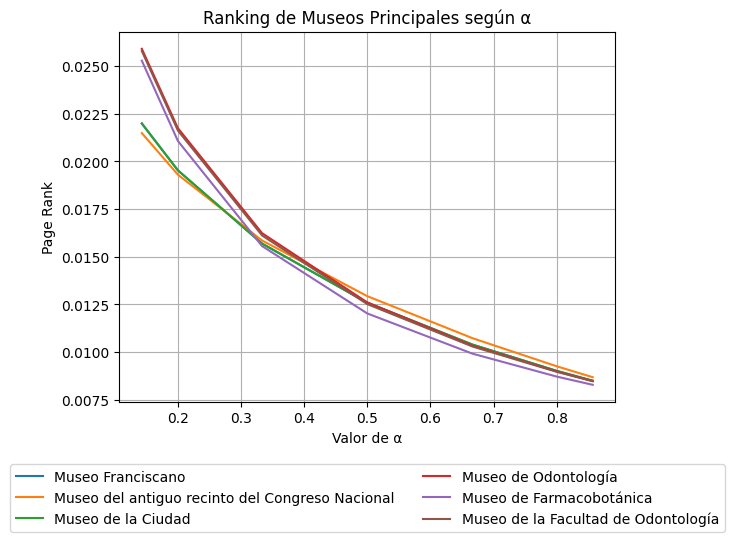

In [14]:
m = 5
lista_alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
ps = [] # Lista de scores page rank para cada m y α
for alpha in lista_alphas:
    pr = calcular_p(D, m, alpha)
    ps.append(pr)

def graficar_museos_principales_por_alpha(ps, alpha):
    # Grafica cómo cambia el ranking de los 3 principales museos para distintos valores de α, con m fijo.
    tres_principales_cada_alpha = []
    for i, p in enumerate(ps):
        principales = np.argsort(p)[-3:]
        tres_principales_cada_alpha.append(principales)
    
    tres_principales_cada_alpha = np.array(list(set(np.hstack(tres_principales_cada_alpha)))) # Eliminar duplicados con set

    nombres_museos = [museos.loc[i, 'name'] for i in tres_principales_cada_alpha] # Sacamos los nombres del dataframe

    for i, museo_i in enumerate(tres_principales_cada_alpha):
        ranking = [p[museo_i] for p in ps]
        plt.plot(alpha, ranking, label=nombres_museos[i])

    plt.xlabel('Valor de α')
    plt.ylabel('Page Rank') 
    plt.title('Ranking de Museos Principales según α')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=2) # Para que los labels no tapen el grafico y queden abajo.
    plt.grid(True)
    plt.show()

graficar_museos_principales_por_alpha(ps, [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7])

IndexError: index 6 is out of bounds for axis 0 with size 6

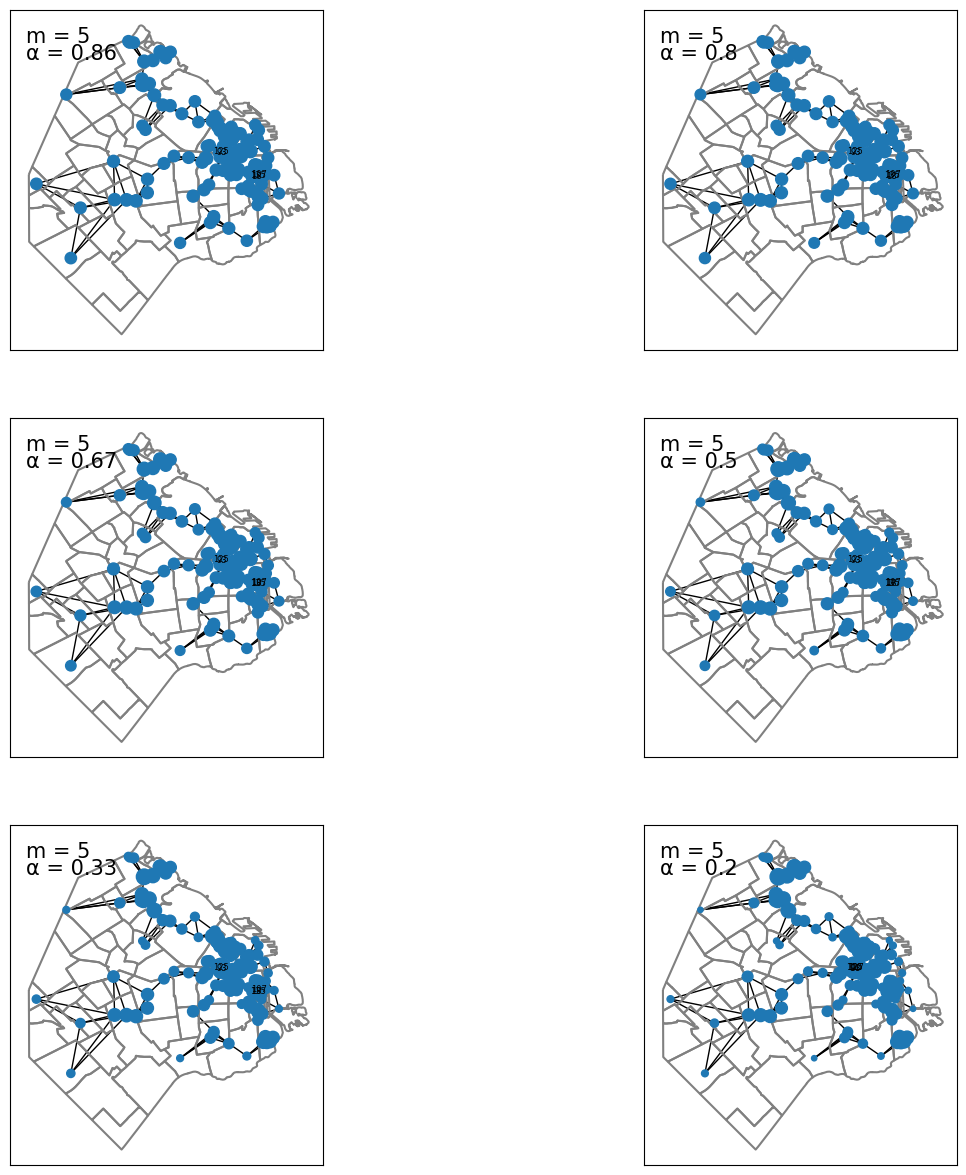

In [15]:
# Mapas para cada par m, α
graficar_red_p_multiple_3x3(ps, A, m, lista_alphas, museos, barrios)

> VALEN: Junten los gráficos

### Conclusiones basadas en la experimentación
Cuando variamos el parametro $m$, las posiciones de los museos en el ranking no son estables. La mayor variacion del ranking se observa entre los valores 1 y 6 de $m$, luego las posiciones se estabilizan.

Para valores bajos de $m$, son mas relevantes museos de la zona Balvanera-Recoleta y Palermo, probablemente porque tienen conexiones directas con otros museos. Para valores altos de $m$, son mas relevantes los de San Nicolas-Monserrat, ya que estos estan conectados indirectamente a mas nodos en la red.

El Museos de Arte Oriental y el de Arte Decorativo son relevantes solo cuando la red tiene pocas conexiones. Por otro lado, el Museo de Casa Rosada no es relevante con bajas conexiones pero si cuando hay muchas conexiones.

Al variar el parametro $\alpha$, las posiciones son mucho mas estables. Existe menor variacion entre las posiciones que cuando comparamos con el parametro $m$.

Cuando $\alpha$ es bajo, los museos mas relevantes son de Recoleta. Y para valores de $\alpha$ altos, son mas relevantes los de San Nicolas-Monserrat.



## Punto 4:

Supongamos que cada persona que ingresa a la red de museos realiza exactamente $r$ visitas antes de abandonar la misma. Sean:

- $\textbf{v} \in \mathbb{R}^N$ el vector que indica la cantidad de personas que ingresaron por primera vez a cada museo, es decir la primera visita.
- $\textbf{w} \in \mathbb{R}^N$ el vector que contiene el número total de visitas que recibió cada museo, contando todas las visitas en los $r$ pasos de cada visitante.
- $C \in \mathbb{R}^{N \times N}$ la matriz de transición de la red de museos.

Sabiendo que luego de $k$ pasos, la distribución de visitantes es $C^k \textbf{v}$, la cantidad total de visitas que recibió cada museo luego de $r$ pasos es la suma de todas las visitas recibidas en los $r-1$ pasos anteriores, es decir

$$ \textbf{w} = \underbrace{\textbf{v}}_{\text{1er visita}} + \underbrace{C\textbf{v}}_{\text{2da visita}} + \underbrace{C^2\textbf{v}}_{\text{3ra visita}} + \cdots + \underbrace{C^{r-1}\textbf{v}}_{r-1\text{-ésima visita}} $$

Luego, sacando a $\textbf{v}$ como factor común tenemos $$ \textbf{w} = (I + C + C^2 + \cdots + C^{r-1}) \textbf{v} $$

$$ \textbf{w} = \left( \sum_{k=0}^{r-1} C^k \right) \textbf{v} $$

llamamos $B = \sum_{k=0}^{r-1} C^k$, de este modo nos queda

$$ \textbf{w} = B\textbf{v} $$

Si asumimos que $B$ es inversible, podemos despejar $\textbf{v}$ como

$$ \textbf{v} = B^{-1}\textbf{w} $$

Que es lo que queríamos probar.

$\square$

## Punto 5:

Nos piden calcular la cantidad total de visitantes que entraron en la red, es decir $||v||_1$,  utilizando la ecuación del punto 4.

$$ \textbf{v} = B^{-1} \textbf{w} $$

Para esto, creamos la función $\texttt{calcula\_matriz\_C\_continua}$ que recibe la matriz de distancias $D$ y calcula $C$ donde

$$ C_{ij}= \frac{f(d_{ij})}{\sum^{N}_{k=1,k\neq i}f(d_{ik})} $$

y la función $\texttt{calcula\_B}$ que toma la matriz $C$ y el número de pasos $r$ y retorna la matriz $B$ donde $$B = \sum^{r-1}_{k=0} C^k$$

FInalmente construimos una función $\texttt{calcular\_v}$ que recibe como parametros el vector $\textbf{w}$ y la matriz de adyacencias $A$ para encontrar $\textbf{v}$. Retorna el vector $\textbf{v}$ y su norma 1.

In [ ]:
# Construimos el vector w con los datos de visitas.txt
w = np.loadtxt("visitas.txt")
# Definimos la cantidad de visitas
r = 3

# Obtenemos el vector de visistas iniciales v y su norma resolviendo la ecuación
norma_v = calcular_v(D, w, r)[0]
v = calcular_v(D, w, r)[1]

# Imprimimos la norma de v y graficamos
print("La cantidad total de visitantes que entraron a la red es ",norma_v)
graficar_histograma_v(v)


## Punto 6:

Supongamos que el número total de visitantes por museo $w$ tiene un error del $5\%$. Queremos poder estimar de qué manera se propaga este error en la estimación del vector $v$ de visitantes iniciales.

Si llamamos $\overline{v}$ y $\overline{w}$ a los valores reales, podemos acotar el error de estimación de la siguiente manera

$$ \frac{||v-\overline{v}||_1}{||v||_1} \leq \text{cond}_1 (B) \frac{||w-\overline{w}||_1}{||w||_1}$$

En este caso como el error de $w$ es del $5\%$, entonces

$$ \frac{||v-\overline{v}||_1}{||v||_1} \leq \text{cond}_1 (B)\ 0.05 $$

In [ ]:
cond = calcular_cond1_de_B(D)

print("Cond1(B): ", cond)
print("Cota: ", cond * 0.05)

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

# Trabajo Práctico 2

## Punto 1 -  Autovectores y autovalores de $L$ y $R$

### a)

Vamos a dividir la demostración en dos casos

Primero demostremos que $\textbf{1}$ es autovalor de la matriz laplaciana $L$. Sabemos que $L = K - A$ donde:
- $A$ es la matriz de adyacencias (simetrica)
- $K$ es la matriz de grados (diagonal) donde $K_{ii} = k_i = \sum^{N}_{j=1} A_{ij}$

Entonces, para que $\textbf{1}$ sea autovector, debe cumplirse que

$$ (K-A)\textbf{1}=\lambda \textbf{1} $$

$$ (K-A)\textbf{1} - \lambda \textbf{1} = 0 $$

$$ (K-A-\lambda I) \textbf{1} = 0 $$ 

Desarrollando la matriz $ (K-A-\lambda I)$ tenemos


$$
 
\begin{pmatrix}
k_1-A_{11}-\lambda & A_{12} & \cdots & A_{NN} \\
A_{21} & \ddots &  & \vdots \\
\vdots &  & \ddots & A_{N-1N} \\
A_{N1} & \cdots & A_{NN-1} & k_N-A_{NN}-\lambda 
\end{pmatrix}

$$

Luego si hacemos el producto nos queda que

$$ \begin{pmatrix}
k_{1} - \lambda - \sum^{N}_{j=1} A_{1j} \\
\vdots \\
k_{N} - \lambda - \sum^{N}_{j=1} A_{Nj}
\end{pmatrix}

=

\begin{pmatrix}
0 \\
\vdots \\
0
\end{pmatrix} 

$$

Pero sabemos que $k_i = \sum^{N}_{j=1} A_{ij}$ por lo tanto

$$

\begin{pmatrix}
k_{1} - \lambda - k_{1} \\
\vdots \\
k_{N} - \lambda - k_{N}
\end{pmatrix} 

=

\begin{pmatrix}
-\lambda \\
\vdots \\
-\lambda 
\end{pmatrix} 

=

\begin{pmatrix}
0 \\
\vdots \\
0 
\end{pmatrix} 
$$

De este modo $\lambda = 0$. Probamos entonces que $\textbf{1}$ es autovector de $L$ de autovalor $0$.

$\square$


Ahora, para la matriz $R = A - P$ donde

- $A$ es la matriz de adyacencias
- $P$ es la matriz donde $P_{ij} = \frac{k_ik_j}{2E}$ con $2E = \sum^{N}_{i=1}\sum^{N}_{j=1} A_{ij}$

Entonces, para que $\textbf{1}$ sea autovector, debe cumplirse que

$$ (A-P)\textbf{1}=\lambda \textbf{1} $$

$$ (A-P)\textbf{1} - \lambda \textbf{1} = 0 $$

$$ (A-P-\lambda I) \textbf{1} = 0 $$ 

La matriz $ (A-P-\lambda I)$ tiene la siguiente forma

$$
 
\begin{pmatrix}
A_{11} - \frac{k_1k_1}{2E} - \lambda & \cdots & A_{1N} - \frac{k_1k_N}{2E}\\
\vdots & \ddots & \vdots \\
A_{N1} - \frac{k_Nk_1}{2E} & \cdots & A_{NN} - \frac{k_Nk_N}{2E} - \lambda
\end{pmatrix}

$$

Notar que en la diagonal principal se resta $\lambda$

Ahora, desarrollando el producto obtenemos

$$ \begin{pmatrix}
\bigl( \sum^{N}_{j=1} A_{1j} - \frac{k_1k_j}{2E} \bigr) - \lambda \\
\vdots \\
\bigl( \sum^{N}_{j=1} A_{Nj} - \frac{k_Nk_j}{2E} \bigr) - \lambda 
\end{pmatrix}

=

\begin{pmatrix}
0 \\
\vdots \\
0
\end{pmatrix} 

\tag{3}
$$

Veamos que pasa con las sumatorias

$$ \sum^{N}_{j=1} A_{ij} - \frac{k_ik_j}{2E} $$

Separamos las sumatorias

$$ = \sum^{N}_{j=1} A_{ij} - \sum^{N}_{j=1} \frac{k_ik_j}{2E} $$ 

Recordemos que $k_i = \sum^{N}_{j=1} A_{ij}$

$$ = k_i - \sum^{N}_{j=1} \frac{k_ik_j}{2E} $$

$$ = k_i - \frac{k_ik_1}{2E} - \dotsc - \frac{k_ik_N}{2E}$$

Sacamos factor común

$$ = \frac{k_i}{2E} \bigl( 2E - k_1 - k_2 - \dotsc - k_N \bigr)$$

Mirando con atención lo que está adentro del parentesis y recordando que $2E = \sum^{N}_{i=1}\sum^{N}_{j=1} A_{ij}$ tenemos que

$$ = \frac{k_i}{2E} \biggl( \sum^{N}_{i=1}\sum^{N}_{j=1} A_{ij} - \sum^{N}_{i=1} k_{i} \biggr)$$

$$ = \frac{k_i}{2E} \biggl( \underbrace{\sum^{N}_{i=1}\sum^{N}_{j=1} A_{ij} - \sum^{N}_{i=1} \sum^{N}_{j=1} A_{ij}}_{=0} \biggr) = 0 $$

Volviendo a $(3)$ 

$$
\begin{pmatrix}
 0 - \lambda \\
\vdots \\
 0 - \lambda 
\end{pmatrix}

=

\begin{pmatrix}
  - \lambda \\
\vdots \\
 - \lambda 
\end{pmatrix}

=

\begin{pmatrix}
0 \\
\vdots \\
0
\end{pmatrix} 
$$

Por lo tanto $\lambda = 0$. De esta manera probamos que $\textbf{1}$ es autovector de $R$ de autovalor $0$.

$\square$

TO DO: ¿Y qué agrupación de la red representa?

### b)

Como $L$ y $R$ son matrices simetricas (por como fueron construidas), basta con tomar una matriz simétrica $M$ y probar esto.

Sea $M\in\mathbb{R}^{N\times N}$ simétrica con dos autovectores $v_1$ y $v_2$ con autovalores distintos $\lambda_1$ y $\lambda_2$. Entonces

$$ Mv_1 = \lambda_1 v_1 \quad \Longrightarrow \quad v_2^{t} M v_1 = v_2^{t} \lambda_1 v_1 \quad \Longrightarrow \quad (Mv_2)^{t}v_1 = \lambda_1 v_2^{t} v_1 \quad \Longrightarrow \quad  (\lambda_2 v_2)^{t}v_1 = \lambda_1 v_2^{t}v_1 $$

$$ \Longrightarrow \quad v_2^{t}\lambda_2 v_1 = \lambda_1 v_2^{t} v_1 \quad \Longrightarrow \quad v_2^{t}\lambda_2 v_1 - \lambda_1 v_2^{t} v_1 = 0 \quad \Longrightarrow \quad (\underbrace{\lambda_2 - \lambda_1}_{\neq 0}) v_2^{t} v_1 = 0 \quad \Longrightarrow \quad v_2^{t} v_1 = 0 $$

Que es lo que queríamos probar. Luego como $M$ es simétrica, en particular vale para $L$ y $R$ simétricas.

$\square$

### c)

Para probar esto, usaremos los incisos probados anteriormente. Probaremos esto con $L$, la demostración es exactamente igual con $R$.

Sea $v = (v_1, \dotsc , v_N) \in \mathbb{R}^{N}$ un autovector de autovalor $\lambda \neq 0$ de $L$, entonces

$$ Lv = \lambda v \tag{4}$$

Por (a) sabemos que $\textbf{1}$ es autovector de $L$ de autovalor $0$, si multiplicamos $\textbf{1}^t$ por $(4)$

$$\textbf{1}^t L v=  \textbf{1}^t \lambda v \quad \Longrightarrow \quad ( L \textbf{1})^t v = \lambda \textbf{1}^t v \quad \overset{\text{por }(1)}{\Longrightarrow} \quad  0 \cdot v = \lambda \textbf{1}^t v \quad \Longrightarrow \quad \lambda \textbf{1}^t v = 0$$

Ahora, como $\lambda \neq 0$, para que esto se cumpla debe suceder que

$$\textbf{1}^t v = 0 \quad \Longrightarrow \quad 1 \cdot v_1 + 1 \cdot v_2 + \dotsc + 1 \cdot v_N = 0 \quad \Longrightarrow \quad \sum^{N}_{i=1} v_i = 0$$

Notar que esto es un caso particular de lo que probamos en (b).

$\square$

## Punto 2 - Extensiones del método de la potencia

###  a)

Sea $M\in\mathbb{R}^{n \times n}$ diagonalizable con autovalores $\lambda_1 \geq \lambda_2 \geq \dotsc \geq \lambda_n$ y autovector $v_i$ asociado a $\lambda_i$.

Sabemos que $M = CDC^{-1}$ pues es diagonalizable, veamos que forma tiene $M+\mu I$

$$M+\mu I = CDC^{-1}+\mu I = C(D+\mu I)C^{-1} =$$

$$
C 
\begin{pmatrix}
  \lambda_1 + \mu & \dotsc & 0\\
\vdots & \ddots & \vdots \\
0 & \dotsc & \lambda_n+\mu
\end{pmatrix}

C^{-1}

$$

Recordemos que como $M$ es diagonalizable, la matriz $C$ esta formada por los autovectores $v_i$ asociados a $\lambda_i$ en sus columnas, es decir

\begin{pmatrix}
| & & | \\
v_1 & \dotsc & v_n \\
| & & | 
\end{pmatrix}

Entonces

$$ M+\mu I = \begin{pmatrix}
| & & | \\
v_1 & \dotsc & v_n \\
| & & | 
\end{pmatrix}
\begin{pmatrix}
  \lambda_1 + \mu & \dotsc & 0\\
\vdots & \ddots & \vdots \\
0 & \dotsc & \lambda_n+\mu
\end{pmatrix}
{\begin{pmatrix}
| & & | \\
v_1 & \dotsc & v_n \\
| & & | 
\end{pmatrix}}^{-1}$$

Con lo cual, probamos que $M+\mu I$ es diagonalizable con autovalores de la forma $\gamma_i = \lambda_i+\mu$ asociados a autovectores $v_i$.

Probemos finalmente que si $\lambda_i+\mu \neq 0$ entonces $M+\mu I$ es inversible

$$(M+\mu I)^{-1} = (CDC^{-1})^{-1} = C^{-1}(D+\mu I)^{-1}C$$

$C$ es inversible pues $M$ es diagonalizable. Luego para que $M$ sea inversible debe suceder que $D+\mu I$ sea inversible, como $D+\mu I$ es diagonal entonces


$$(D+\mu I)^{-1} = 
\begin{pmatrix}
   \frac{1}{\lambda_1 + \mu} & \dotsc & 0\\
\vdots & \ddots & \vdots \\
0 & \dotsc & \frac{1}{\lambda_n+\mu}
\end{pmatrix}
$$

Luego como $\lambda_i+\mu \neq 0$ para $1 \leq i \leq n$ entonces esto es válido y $M+\mu I$ es inversible.

$\square$


### b)

TO DO

### c)

TO DO

## Punto 3 - Implementación

## Punto 4

## Punto 5 - Síntesis final